### What would be an appropriate metric to evaluate your models? Why? (Hint: No code required.)

Since no specific cost is given, accuracy seems like the best metric to be used since we assume that all class are equally important. Accuracy is also intuitive to understand the performance of each of the models. Hence, in this assignment, we will choose accuracy as the mertric of choice.

_____

### Get the data and show some example images from the data.

In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

In [2]:
from keras.datasets import fashion_mnist

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
# Look at the dimensions
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

X_train: (60000, 28, 28)
y_train: (60000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


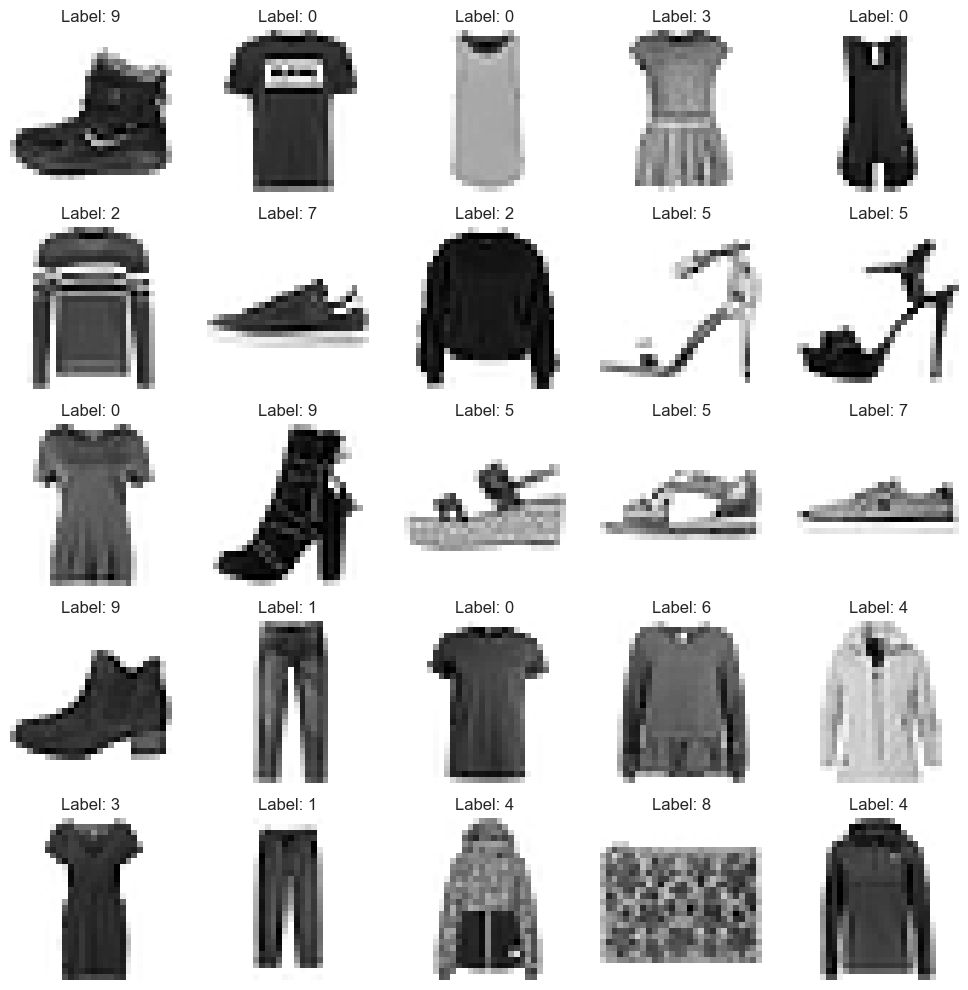

In [4]:
# Visualize some items in a grid
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train[i], cmap="binary")
    ax.axis("off")
    ax.set_title(f"Label: {y_train[i]}")
plt.tight_layout()
plt.show()

### Train a simple fully connected single hidden layer network to predict the items. Remember to normalize the data similar to what we did in class. Make sure that you use enough epochs so that the validation error begins to level off - provide a plot of the training history.

In [5]:
from sklearn.model_selection import train_test_split

prng = np.random.RandomState(20240329)  # ensure we have the same split as in last class

# intentionally choose a small train set to decrease computational burden
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=prng)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:  {X_val.shape}")
print(f"y_val:  {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

X_train: (42000, 28, 28)
y_train: (42000,)
X_val:  (18000, 28, 28)
y_val:  (18000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


In [6]:
# Benchmark #1 (silly):

from sklearn.metrics import accuracy_score
from statistics import mode

most_frequent = mode(y_train)
print(f"Most frequent element is: {most_frequent}")
accuracy_most_frequent = accuracy_score(y_val, np.repeat(most_frequent, len(y_val)))
print(f"Accuracy for our no-brainer model: {round(accuracy_most_frequent, 4)}")
summary_df = pd.DataFrame({'Model': ['Benchmark'],
                           'Train accuracy': [round(accuracy_score(np.array([most_frequent] * len(y_train)), y_train), 4)],
                           'Val accuracy': [round(accuracy_score(np.array([most_frequent] * len(y_val)), y_val), 4)],
                           'Test accuracy': [round(accuracy_score(np.array([most_frequent] * len(y_test)), y_test), 4)],
                          })
summary_df

Most frequent element is: 7
Accuracy for our no-brainer model: 0.0944


,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1


In [7]:
def update_summary(summary_df, model_name, train_score, val_score, test_score):
    if model_name not in summary_df.Model.values:
        summary_df.loc[len(summary_df.index)] = [model_name, 
                                                 '{:.4f}'.format(train_score),
                                                 '{:.4f}'.format(val_score),
                                                 '{:.4f}'.format(test_score)]
    else:
        summary_df.loc[summary_df.Model == model_name] = [model_name, 
                                                 '{:.4f}'.format(train_score),
                                                 '{:.4f}'.format(val_score),
                                                 '{:.4f}'.format(test_score)]

In [8]:
from sklearn.pipeline import Pipeline
# Benchmark #2 (RF):
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer

def flatten_data(X):
    return X.reshape(X.shape[0], -1)

transformer = FunctionTransformer(flatten_data)

rf_model = Pipeline(
    [("preprocess", transformer),
     ("rf", RandomForestClassifier(random_state = prng))
     ], verbose=True
)

rf_model.fit(X_train, y_train)
predictions_rf = rf_model.predict(X_val)
accuracy_score(y_val, predictions_rf)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total=  38.7s


0.8811666666666667

In [10]:
update_summary(summary_df, 'Random Forest', accuracy_score(y_train, rf_model.predict(X_train)), accuracy_score(y_val, predictions_rf), accuracy_score(y_test, rf_model.predict(X_test)))
summary_df

,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699


In [11]:
from keras.utils import to_categorical

print(f"Dimension of y: {y_train.shape}")

# Convert target variables to categorical
num_classes = 10
y_sets = [y_train, y_test, y_val]
y_train, y_test, y_val = [to_categorical(y, num_classes=num_classes) for y in y_sets]
print(f"Dimension of y: {y_train.shape}")

Dimension of y: (42000,)
Dimension of y: (42000, 10)


In [12]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Rescaling, Dense
from keras.utils import to_categorical

# Build the simple fully connected single hidden layer network model
model = Sequential([
    Input(shape=X_train.shape[1:]), 
    Flatten(), 
    Rescaling(1./255), 
    Dense(255, activation='relu'), 
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 255)            │       200,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,735 (791.93 KB)

 Trainable params: 202,735 (791.93 KB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
import keras

# Fit the model
keras.utils.set_random_seed(20240329)  # for reproducibility
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6642 - loss: 1.0124 - val_accuracy: 0.8106 - val_loss: 0.5364
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8280 - loss: 0.4973 - val_accuracy: 0.8304 - val_loss: 0.4786
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8465 - loss: 0.4411 - val_accuracy: 0.8349 - val_loss: 0.4592
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8565 - loss: 0.4104 - val_accuracy: 0.8446 - val_loss: 0.4345
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8643 - loss: 0.3854 - val_accuracy: 0.8557 - val_loss: 0.4064
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8718 - loss: 0.3624 - val_accuracy: 0.8572 - val_loss: 0.3973
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8773 - loss: 0.3472 - val_accuracy: 0.8647 - val_loss: 0.3801
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8837 - loss: 0.3312 - val_accuracy: 0.8671 - v

In [14]:
# Evaluation of the model on the validation set
scores = model.evaluate(X_val, y_val)
print(f"Accuracy for keras single hidden layer: {round(scores[1], 4)}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.8852 - loss: 0.4615
Accuracy for keras single hidden layer: 0.888


Before building the simple fully connected single hidden layer network, we build a naive most frequent model and a Random Forest model as benchmarks.

The simple fully connected single hidden layer network consists of:
- Normalize layer to like we did in class
- A single hidden layer with 255 neurons
- An output layer with 10 neurons representing 10 classes and uses 'softmax' as activation function

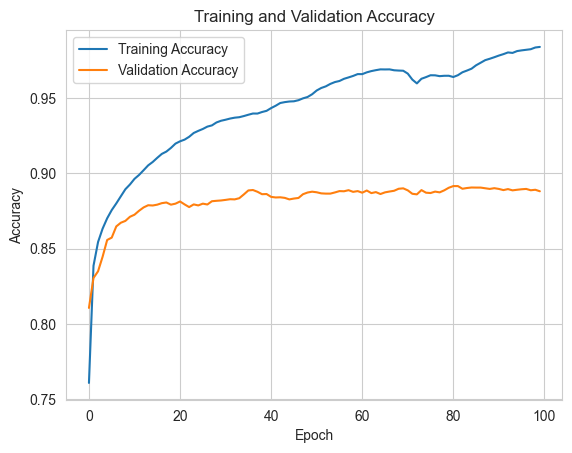

In [15]:
def plot_history(fit_history):
    plt.plot(fit_history['accuracy'], label='Training Accuracy')
    plt.plot(fit_history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_history(history.history)

In [16]:
update_summary(summary_df, 'Single Hidden Layer', model.evaluate(X_train, y_train)[1], scores[1], model.evaluate(X_test, y_test)[1])
summary_df

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 405us/step - accuracy: 0.9683 - loss: 0.0839
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.8835 - loss: 0.5033


,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699
2,Single Hidden Layer,0.9690,0.8880,0.8806


From the summary table, the simple fully connected single hidden layer network outperforms the benchmark and random forest models. Although on the train data, the simple networks does not generalize as perfect as the random forest, on validation and test data, it performs much better, meaning it avoid the overfitting problem that exist in the random forest model.

From the history graph, it seems the validation accuracy flattens out pretty quickly. We can probably stop the training earlier and still obtain the same performance on the validation and test data.

_____

### Experiment with different network architectures and settings (number of hidden layers, number of nodes, regularization, etc.). Train at least 3 models. Explain what you have tried and how it worked.

In [17]:
# Build the fully connected 3 hidden layers network model
hidden3_model = Sequential([
    Input(shape=X_train.shape[1:]), 
    Flatten(), 
    Rescaling(1./255), 
    Dense(255, activation='relu'), 
    Dense(510, activation='relu'), 
    Dense(1020, activation='relu'), 
    Dense(num_classes, activation='softmax')
])

# Compile the model
hidden3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(hidden3_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 255)            │       200,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 510)            │       130,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1020)           │       521,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        10,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 862,165 (3.29 MB)

 Trainable params: 862,165 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
# Fit the model
keras.utils.set_random_seed(20240329)  # for reproducibility
hidden3_history = hidden3_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6855 - loss: 0.9137 - val_accuracy: 0.8058 - val_loss: 0.5150
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8382 - loss: 0.4465 - val_accuracy: 0.7984 - val_loss: 0.5346
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8568 - loss: 0.3925 - val_accuracy: 0.8566 - val_loss: 0.3828
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8773 - loss: 0.3349 - val_accuracy: 0.8730 - val_loss: 0.3478
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8881 - loss: 0.3021 - val_accuracy: 0.8750 - val_loss: 0.3459
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8953 - loss: 0.2803 - val_accuracy: 0.8809 - val_loss: 0.3306
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9028 - loss: 0.2606 - val_accuracy: 0.8841 - val_loss: 0.3248
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9072 - loss: 0.2461 - val_accuracy: 0.

In [19]:
# Evaluation of the model on the validation set
hidden3_scores = hidden3_model.evaluate(X_val, y_val)
print(f"Accuracy for keras 3 hidden layers: {round(hidden3_scores[1], 4)}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8873 - loss: 0.8214
Accuracy for keras 3 hidden layers: 0.8895


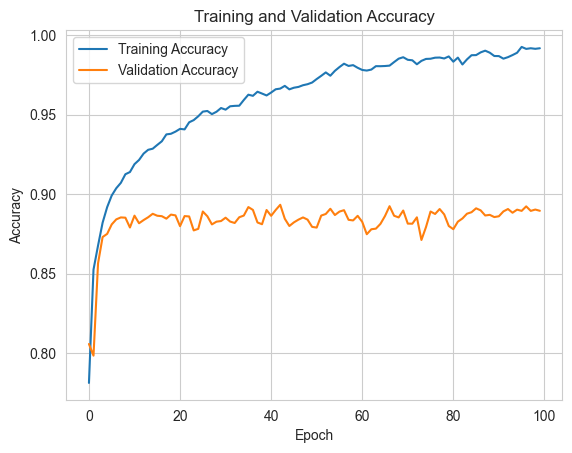

In [20]:
plot_history(hidden3_history.history)

In [21]:
update_summary(summary_df, '3 Hidden Layers', hidden3_model.evaluate(X_train, y_train)[1], hidden3_scores[1], hidden3_model.evaluate(X_test, y_test)[1])
summary_df

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9820 - loss: 0.0507
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8818 - loss: 0.9179


,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699
2,Single Hidden Layer,0.9690,0.8880,0.8806
3,3 Hidden Layers,0.9812,0.8895,0.8820


In [22]:
from keras.layers import Dropout

# Build the regularized 3 hidden layers network model
reg_hidden3_model = Sequential([
    Input(shape=X_train.shape[1:]), 
    Flatten(), 
    Rescaling(1./255), 
    Dense(255, activation='relu'), 
    Dropout(0.2),
    Dense(510, activation='relu'), 
    Dropout(0.2),
    Dense(1020, activation='relu'), 
    Dense(num_classes, activation='softmax')
])

# Compile the model
reg_hidden3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(reg_hidden3_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 255)            │       200,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 255)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 510)            │       130,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 510)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1020)           │       521,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │        10,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 862,165 (3.29 MB)

 Trainable params: 862,165 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
from keras.callbacks import EarlyStopping

# Fit the model with EarlyStopping
keras.utils.set_random_seed(20240329)  # for reproducibility
reg_hidden3_history = reg_hidden3_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512, callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, verbose=1)])

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6436 - loss: 0.9985 - val_accuracy: 0.8181 - val_loss: 0.4988
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8301 - loss: 0.4691 - val_accuracy: 0.8364 - val_loss: 0.4344
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8500 - loss: 0.4068 - val_accuracy: 0.8414 - val_loss: 0.4260
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8616 - loss: 0.3807 - val_accuracy: 0.8681 - val_loss: 0.3583
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8732 - loss: 0.3402 - val_accuracy: 0.8572 - val_loss: 0.3854
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8771 - loss: 0.3378 - val_accuracy: 0.8769 - val_loss: 0.3348
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8831 - loss: 0.3163 - val_accuracy: 0.8652 - val_loss: 0.3714
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8819 - loss: 0.3162 - val_accuracy: 0.

In [24]:
# Evaluation of the model on the validation set
reg_hidden3_model_scores = reg_hidden3_model.evaluate(X_val, y_val)
print(f"Accuracy for keras regularized 3 hidden layers: {round(hidden3_scores[1], 4)}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8936 - loss: 0.3469
Accuracy for keras regularized 3 hidden layers: 0.8895


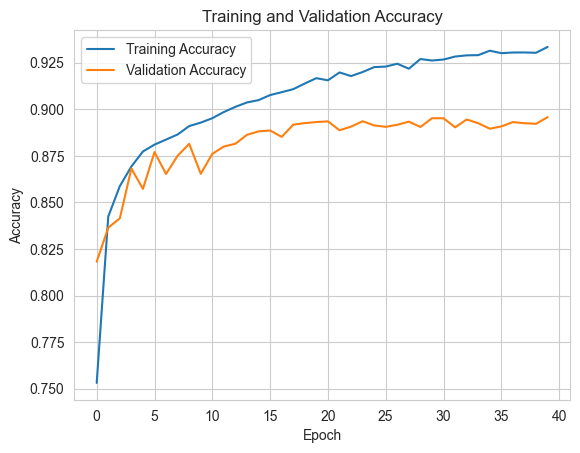

In [25]:
plot_history(reg_hidden3_history.history)

In [26]:
update_summary(summary_df, 'Regularized 3 Hidden Layers', reg_hidden3_model.evaluate(X_train, y_train)[1], reg_hidden3_model_scores[1], reg_hidden3_model.evaluate(X_test, y_test)[1])
summary_df

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9463 - loss: 0.1434
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8852 - loss: 0.3621


,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699
2,Single Hidden Layer,0.9690,0.8880,0.8806
3,3 Hidden Layers,0.9812,0.8895,0.8820
4,Regularized 3 Hidden Layers,0.9450,0.8957,0.8859


In [27]:
# Build the regularized 5 hidden layers network model
reg_hidden5_model = Sequential([
    Input(shape=X_train.shape[1:]), 
    Flatten(), 
    Rescaling(1./255), 
    Dense(255, activation='relu'), 
    Dropout(0.2),
    Dense(510, activation='relu'), 
    Dropout(0.2),
    Dense(1020, activation='relu'), 
    Dropout(0.2),
    Dense(2040, activation='relu'), 
    Dropout(0.2),
    Dense(255, activation='relu'), 
    Dense(num_classes, activation='softmax')
])

# Compile the model
reg_hidden5_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(reg_hidden5_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 255)            │       200,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 255)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 510)            │       130,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 510)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1020)           │       521,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1020)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2040)           │     2,082,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2040)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 255)            │       520,455 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         2,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457,810 (13.19 MB)

 Trainable params: 3,457,810 (13.19 MB)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
# Fit the model with EarlyStopping
keras.utils.set_random_seed(20240329)  # for reproducibility
reg_hidden5_history = reg_hidden5_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512, callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, verbose=1)])

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5971 - loss: 1.0709 - val_accuracy: 0.8051 - val_loss: 0.5088
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8199 - loss: 0.4872 - val_accuracy: 0.8278 - val_loss: 0.4701
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8437 - loss: 0.4204 - val_accuracy: 0.8385 - val_loss: 0.4484
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8583 - loss: 0.3910 - val_accuracy: 0.8599 - val_loss: 0.3927
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8676 - loss: 0.3571 - val_accuracy: 0.8584 - val_loss: 0.3820
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8755 - loss: 0.3401 - val_accuracy: 0.8647 - val_loss: 0.3726
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8778 - loss: 0.3316 - val_accuracy: 0.8651 - val_loss: 0.3671
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8797 - loss: 0.3229 - val_accuracy: 0.

In [29]:
# Evaluation of the model on the validation set
reg_hidden5_model_scores = reg_hidden5_model.evaluate(X_val, y_val)
print(f"Accuracy for keras regularized 5 hidden layers: {round(reg_hidden5_model_scores[1], 4)}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8898 - loss: 0.3419
Accuracy for keras regularized 5 hidden layers: 0.8915


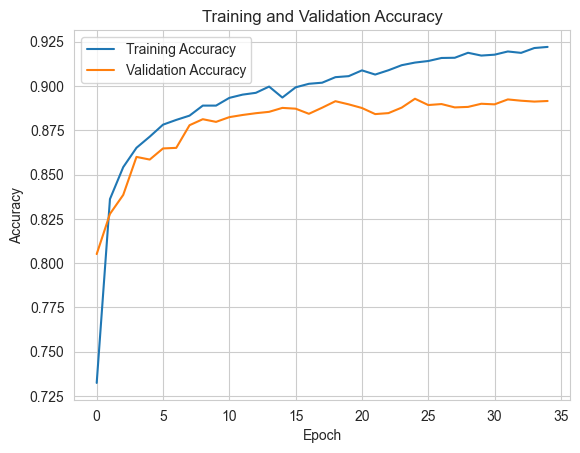

In [30]:
plot_history(reg_hidden5_history.history)

In [31]:
update_summary(summary_df, 'Regularized 5 Hidden Layers', reg_hidden5_model.evaluate(X_train, y_train)[1], reg_hidden5_model_scores[1], reg_hidden5_model.evaluate(X_test, y_test)[1])
summary_df

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9346 - loss: 0.1700
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8844 - loss: 0.3673


,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699
2,Single Hidden Layer,0.9690,0.8880,0.8806
3,3 Hidden Layers,0.9812,0.8895,0.8820
4,Regularized 3 Hidden Layers,0.9450,0.8957,0.8859
5,Regularized 5 Hidden Layers,0.9341,0.8915,0.8850


### Try to improve the accuracy of your model by using convolution. Train at least two different models (you can vary the number of convolutional and pooling layers or whether you include a fully connected layer before the output, etc.).

In [32]:
from keras.layers import Conv2D, MaxPooling2D, Reshape

# Build the single cnn network model
cnn1_model = Sequential([
    Input(shape=X_train.shape[1:]), 
    Reshape(target_shape=(X_train.shape[1], X_train.shape[2], 1)),  # explicitly state the 4th (channel) dimension
    Rescaling(1./255), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(), 
    Dropout(0.2),
    Dense(255, activation='relu'), 
    Dropout(0.2),
    Dense(127, activation='relu'), 
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn1_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn1_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 255)            │     1,379,295 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 255)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 127)            │        32,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 127)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,413,407 (5.39 MB)

 Trainable params: 1,413,407 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

None


In [33]:
# Fit the model with EarlyStopping
keras.utils.set_random_seed(20240329)  # for reproducibility
cnn1_history = cnn1_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512, callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, verbose=1)])

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6439 - loss: 1.0604 - val_accuracy: 0.8596 - val_loss: 0.4078
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8449 - loss: 0.4364 - val_accuracy: 0.8831 - val_loss: 0.3345
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8740 - loss: 0.3538 - val_accuracy: 0.8877 - val_loss: 0.3136
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8847 - loss: 0.3196 - val_accuracy: 0.8960 - val_loss: 0.2870
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8944 - loss: 0.2907 - val_accuracy: 0.8999 - val_loss: 0.2758
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9019 - loss: 0.2684 - val_accuracy: 0.9067 - val_loss: 0.2588
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9094 - loss: 0.2481 - val_accuracy: 0.9063 - val_loss: 0.2594
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9118 - loss: 0.2346 - val_accuracy: 0.

In [34]:
# Evaluation of the model on the validation set
cnn1_model_scores = cnn1_model.evaluate(X_val, y_val)
print(f"Accuracy for keras single cnn layer: {round(cnn1_model_scores[1], 4)}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9148 - loss: 0.3235
Accuracy for keras single cnn layer: 0.9146


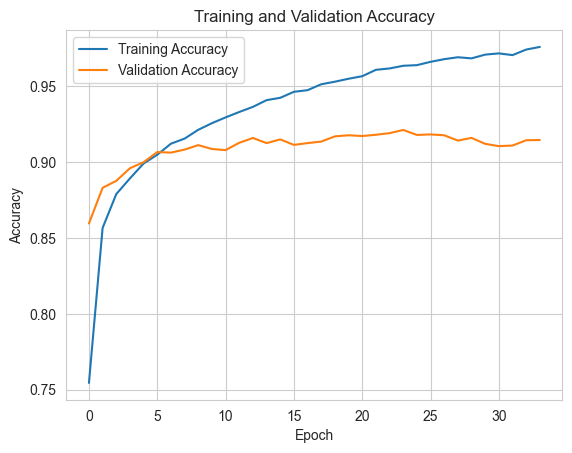

In [35]:
plot_history(cnn1_history.history)

In [36]:
update_summary(summary_df, 'Single CNN Layer', cnn1_model.evaluate(X_train, y_train)[1], cnn1_model_scores[1], cnn1_model.evaluate(X_test, y_test)[1])
summary_df

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9849 - loss: 0.0428
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9077 - loss: 0.3588


,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699
2,Single Hidden Layer,0.9690,0.8880,0.8806
3,3 Hidden Layers,0.9812,0.8895,0.8820
4,Regularized 3 Hidden Layers,0.9450,0.8957,0.8859
5,Regularized 5 Hidden Layers,0.9341,0.8915,0.8850
6,Single CNN Layer,0.9842,0.9146,0.9109


In [37]:
# Build the single cnn network model
cnn2_model = Sequential([
    Input(shape=X_train.shape[1:]),
    Reshape(target_shape=(X_train.shape[1], X_train.shape[2], 1)),  # explicitly state the 4th (channel) dimension
    Rescaling(1. / 255),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.2),
    Dense(255, activation='relu'),
    Dropout(0.2),
    Dense(127, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn2_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn2_model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 255)            │       987,615 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 255)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 127)            │        32,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 127)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,040,511 (3.97 MB)

 Trainable params: 1,040,511 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
# Fit the model with EarlyStopping
keras.utils.set_random_seed(20240329)  # for reproducibility
cnn2_history = cnn2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512, callbacks=[
    EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, verbose=1)])

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.5896 - loss: 1.1510 - val_accuracy: 0.8422 - val_loss: 0.4522
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8241 - loss: 0.4803 - val_accuracy: 0.8671 - val_loss: 0.3780
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8594 - loss: 0.3959 - val_accuracy: 0.8807 - val_loss: 0.3360
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8714 - loss: 0.3547 - val_accuracy: 0.8849 - val_loss: 0.3156
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8802 - loss: 0.3318 - val_accuracy: 0.8973 - val_loss: 0.2851
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8928 - loss: 0.2935 - val_accuracy: 0.9017 - val_loss: 0.2734
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9003 - loss: 0.2781 - val_accuracy: 0.9033 - val_loss: 0.2646
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9052 - loss: 0.2565 - val_accuracy: 0

In [39]:
# Evaluation of the model on the validation set
cnn2_model_scores = cnn2_model.evaluate(X_val, y_val)
print(f"Accuracy for keras 2 cnn layers: {round(cnn2_model_scores[1], 4)}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9194 - loss: 0.2854
Accuracy for keras 2 cnn layers: 0.9212


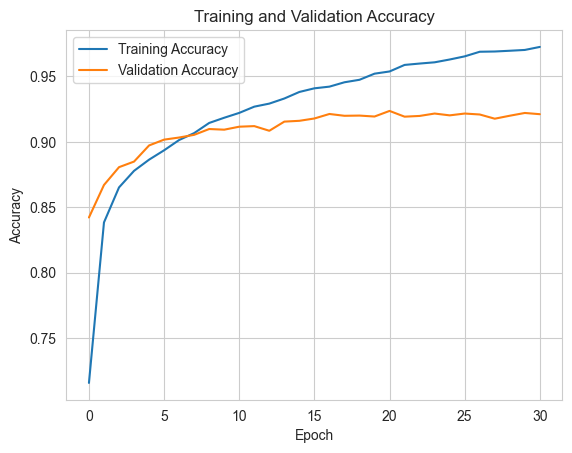

In [40]:
plot_history(cnn2_history.history)

In [41]:
update_summary(summary_df, '2 CNN Layers', cnn2_model.evaluate(X_train, y_train)[1], cnn2_model_scores[1],
               cnn2_model.evaluate(X_test, y_test)[1])
summary_df

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9893 - loss: 0.0344
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9159 - loss: 0.3172


,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699
2,Single Hidden Layer,0.9690,0.8880,0.8806
3,3 Hidden Layers,0.9812,0.8895,0.8820
4,Regularized 3 Hidden Layers,0.9450,0.8957,0.8859
5,Regularized 5 Hidden Layers,0.9341,0.8915,0.8850
6,Single CNN Layer,0.9842,0.9146,0.9109
7,2 CNN Layers,0.9884,0.9212,0.9188


### Try to use a pre-trained network to improve accuracy.

In [42]:
import tensorflow as tf

def preprocess_resnet(images):
    images = np.stack([images]*3, axis=-1) / 255.0  # Convert to 3 channels and normalize
    images = tf.image.resize(images, [32, 32])  # Resize images
    return images

# Load and preprocess data
X_train_resnet = preprocess_resnet(X_train)
X_val_resnet = preprocess_resnet(X_val)
X_test_resnet = preprocess_resnet(X_test)

X_train_resnet.shape

TensorShape([42000, 32, 32, 3])

In [48]:
from keras.applications.efficientnet import EfficientNetB0
from keras.layers import GlobalAveragePooling2D
from keras.applications import ResNet50, ResNet101
from keras.models import Model


# Load pre-trained ResNet101 model without the top layers as we do not want to classify for 1000 classes but only simple binary
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
base_model.trainable = False

# Model definition
output = base_model.output
output = GlobalAveragePooling2D()(output)
output = Dense(256, activation="relu")(output)
output = Dense(10, activation="softmax")(output)
fine_tuned_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
fine_tuned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check the architecture
print(fine_tuned_model.summary())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [49]:
# Fit the model with EarlyStopping
keras.utils.set_random_seed(20240329)  # for reproducibility
fine_tune_history = fine_tuned_model.fit(X_train_resnet, y_train, validation_data=(X_val_resnet, y_val), epochs=10, callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001, verbose=1)])

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 87s 64ms/step - accuracy: 0.5556 - loss: 1.2216 - val_accuracy: 0.7284 - val_loss: 0.7626
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 79s 60ms/step - accuracy: 0.7144 - loss: 0.7542 - val_accuracy: 0.7484 - val_loss: 0.7116
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.7351 - loss: 0.7005 - val_accuracy: 0.7658 - val_loss: 0.6664
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.7460 - loss: 0.6724 - val_accuracy: 0.7729 - val_loss: 0.6344
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 84s 64ms/step - accuracy: 0.7520 - loss: 0.6544 - val_accuracy: 0.7769 - val_loss: 0.6138
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 89s 68ms/step - accuracy: 0.7575 - loss: 0.6410 - val_accuracy: 0.7771 - val_loss: 0.6073
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 86s 66ms/step - accuracy: 0.7631 - loss: 0.6278 - val_accuracy: 0.7762 - val_loss: 0.6020
Epoch 8/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 85s 65ms/step - accuracy: 0.7666 -

In [50]:
# Evaluation of the model on the validation set
fine_tuned_model_scores = fine_tuned_model.evaluate(X_val_resnet, y_val)
print(f"Accuracy for pretrained model: {round(fine_tuned_model_scores[1], 4)}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.7787 - loss: 0.5926
Accuracy for pretrained model: 0.7833


In [51]:
update_summary(summary_df, 'Pre-Trained Model', fine_tuned_model.evaluate(X_train_resnet, y_train)[1], fine_tuned_model_scores[1], fine_tuned_model.evaluate(X_test_resnet, y_test)[1])
summary_df

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 58s 44ms/step - accuracy: 0.7817 - loss: 0.5789
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7717 - loss: 0.6013


,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699
2,Single Hidden Layer,0.9690,0.8880,0.8806
3,3 Hidden Layers,0.9812,0.8895,0.8820
4,Regularized 3 Hidden Layers,0.9450,0.8957,0.8859
5,Regularized 5 Hidden Layers,0.9341,0.8915,0.8850
6,Single CNN Layer,0.9842,0.9146,0.9109
7,2 CNN Layers,0.9884,0.9212,0.9188
8,Pre-Trained Model,0.7822,0.7833,0.7732


### Select a final model and evaluate it on the test set. How does the test error compare to the validation error?

In [52]:
summary_df

,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699
2,Single Hidden Layer,0.9690,0.8880,0.8806
3,3 Hidden Layers,0.9812,0.8895,0.8820
4,Regularized 3 Hidden Layers,0.9450,0.8957,0.8859
5,Regularized 5 Hidden Layers,0.9341,0.8915,0.8850
6,Single CNN Layer,0.9842,0.9146,0.9109
7,2 CNN Layers,0.9884,0.9212,0.9188
8,Pre-Trained Model,0.7822,0.7833,0.7732


From the summary table, the model with the highest test accuracy is the 2 CNN Layers, which has a test accuracy of 0.9188. This model also shows high validation accuracy (0.9212), indicating good generalization from the training to the unseen data. The test error for this model is 1 - 0.9188 = 0.0812, and the validation error is 1 - 0.9212 = 0.0788. The very close performance on both the validation and test sets suggests that the model generalizes well, with only a slight increase in error from validation to test, indicating minimal overfitting.